# Retrieval Augmented Diffusion Model for Time-Series Forecasting

# References

Paper: [**Retrieval-Augmented Diffusion Models for Time Series Forecasting**](https://openreview.net/pdf?id=dRJJt0Ji48)<br/>
Dataset: [**HouseTS Dataset from Kaggle**](https://www.kaggle.com/datasets/shengkunwang/housets-dataset)

# Project aim and paper description

The project aims to implement a generative model for time-series forecasting, applying it to a house-price and socioeconomic dataset. As demostrated in the paper, the model improves the general diffusion model framework by adding embedding-based retrieval mechanism that retrieves series sharing similar patterns from a reference database. It improves the model generation by exploiting the references, to overcome the lack of guidance in the forecasting process, leading to more accurate and context-aware forecasts.<br/>
In particular the framework proposed in the paper suggested to use a pre-trained encoder for time-series. The encoder compresses time-series, simplifying the task of finding series with similar patterns. It is also produced an index of the embeddings for a fast retrieval of the reference. </br> 

# Theoretical background and key concepts

Retrieval-Augmented Time-Series Diffusion (RATD) is based on the theory of diffusion probabilistic models, which are generative models that learn to reverse a Markovian forward noising process. These models are designed to learn the reverse of a forward noising process, where an original sample x0​ is progressively corrupted into xT​. <br/>

The model takes as input a time-series, where the tail of the series is completely filled with noise, and the model is able to recostruct the original signal, exploiting the context retrieved by the head of the series, the references and the side information.</br>

As previously described, the references were found by looking at the k-nearest neighbours in a lower dimensional space, with respect to the head of the series, and we take as references the tails of those neighbours. <br/>

The side information is obtained by concatenating the temporal embeddings with the feature embeddings, where the temporal embeddings are sinusoidal positional embeddings, while the feature embeddings are learnable positional embeddings.  

These embeddings are concatenated and fed into attention modules based on a Transformer architecture.

The model adopts a lightweight attention mechanism inspired by CSDI, consisting of alternating temporal and feature Transformer layers. By using linear attention, RATD is able to handle long sequences and large datasets more efficiently.

# Reproducibility

We both launched this notebook on our machines and on Kaggle notebooks. Before starting the process is required to import all the modules defined in the import section. It is also necessary to have available the auto-encoder for housets defined in the notebook "autoencoder_for_housets.ipynb". You can direclty find the pre-trained auto-encoder model in the folder "models", with the name "encoder.pth".

# Import

In [1]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 62.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install linear-attention-transformer

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install torch_timeseries

Note: you may need to restart the kernel to use updated packages.


In [26]:
import torch
import torch.nn as nn
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from linear_attention_transformer import LinearAttentionTransformer
import math 
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import faiss
from IPython.display import display
import random
from sklearn.utils import shuffle

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # conflict between faiss and pytorch libraries 

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data extraction and preprocessing

In this section we extract the time series from the CSV file. <br/>
The original dataset contains entries of the form <date, median_sale_price, median_list_price, median_ppsf, median_list_ppsf, homes_sold, pending_sales, new_listings, inventory, median_dom, avg_sale_to_list, sold_above_list, off_market_in_two_weeks, city, zipcode, year, bank, bus, hospital, mall, park, restaurant, school, station, supermarket, Total Population, Median Age, Per Capita Income, Total Families Below Poverty, Total Housing Units, Median Rent,Median Home Value, Total Labor Force, Unemployed Population, Total School Age Population, Total School Enrollment, Median Commute Time, price, city_full>, where the combination of <zipcode, year> is a key for the dataset. 
The HouseTS dataset contains also satellite images, grouped by zipocode in different folders. For this reason we decided to keep only the entries relative to zones linked to images. 
The zipcode is a representative value for each zone of Washington.</br>
We extract time series of length of 24 steps (24 months), where our final aim is to predict the last 12 timesteps given the previous 12s. </br>
As preprocessing we dropped non relevant features in this simplified scenario, and we also extracted metadata: zipcode, timestamp, year.  

In [28]:
window_length = 168 + 192
step_size = 1

In [29]:
csv_file = "/kaggle/input/ettsmall/ETTm1.csv"
df = pd.read_csv(csv_file)

In [30]:
# 1. Order by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

def extract_windows(df, window_len, step):
    windows = []
    timestamps = []
    
    # Drop non-numeric columns for window extraction
    numeric_df = df.drop(columns=["date"])
    
    for i in range(step - 1, len(df) - window_len + 1, step):
        # Window of numeric features
        window = numeric_df.iloc[i:i+window_len].values
        windows.append(window)
        
        # Associate timestamps
        timestamps.append(df["date"].iloc[i:i+window_len].values)
    
    return np.array(windows), np.array(timestamps)

all_windows, all_timestamps = extract_windows(df, window_length, step_size)

X = all_windows  # shape: (num_samples, window_length, num_features)
meta_time = all_timestamps  # metadata: array of associated dates

print("Shape of X:", X.shape)               # (num_samples, window_length, num_features)
print("Shape of meta_time:", meta_time.shape)  # (num_samples, window_length)

Shape of X: (69321, 360, 7)
Shape of meta_time: (69321, 360)


We shuffled the dataset fixing the seed for replication purposes, then we splitted the dtaset for the training, evaluation and testing, respectively with a proportion 70%, 10% 20%. We normalized the datasets, according to the training dataset. Finally we created the DataLoaders, with a batch size of 32. 

In [31]:
# Ensure the dataframe is sorted by date
df["date"] = pd.to_datetime(df["date"])

# Define time boundaries
start_date = df["date"].min()
train_end = start_date + pd.DateOffset(months=12)
val_end = train_end + pd.DateOffset(months=4)
test_end = val_end + pd.DateOffset(months=4)

# Create masks for each split
train_mask = [all(d < train_end for d in window) for window in meta_time]
val_mask   = [all((d >= train_end) and (d < val_end) for d in window) for window in meta_time]
test_mask  = [all((d >= val_end) and (d < test_end) for d in window) for window in meta_time]

# Apply the masks
X_train = X[train_mask]
X_val   = X[val_mask]
X_test  = X[test_mask]

meta_train = [m for m, flag in zip(meta_time, train_mask) if flag]
meta_val   = [m for m, flag in zip(meta_time, val_mask) if flag]
meta_test  = [m for m, flag in zip(meta_time, test_mask) if flag]

print(len(X_train), len(X_val), len(X_test))

34681 11449 11161


In [32]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, meta, seq_len=None):
        self.X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        self.meta = meta
        self.seq_len = seq_len or X.shape[1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        meta_window = self.meta[idx]
        
        # Convert dates → UNIX timestamps
        timestamps = [int(pd.Timestamp(date).timestamp()) for date in meta_window]
        years = [pd.Timestamp(date).year for date in meta_window]
        
        return x, torch.tensor(timestamps, dtype=torch.long), torch.tensor(years, dtype=torch.long)


In [33]:
# Compute the statistics of the train dataset and normalize with respect to it 
mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape (1, 1, num_features)
std = X_train.std(axis=(0, 1), keepdims=True)

X_train_norm = (X_train - mean) / std
X_val_norm = (X_val - mean) / std
X_test_norm = (X_test - mean) / std

train_dataset = TimeSeriesDataset(X_train_norm, meta_train)
val_dataset = TimeSeriesDataset(X_val_norm, meta_val)
test_dataset = TimeSeriesDataset(X_test_norm, meta_test)

X_train_tensor =  train_dataset.X

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Retrieval Database

We reloaded the pre-trained encoder-decoder to embed the train dataset and build an efficient retrieval database for top k nearest neighbours search. 

In [34]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation  # full causal
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)

        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)

        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2,
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)
        out = self.net(x)
        if out.shape != res.shape:
            # Align time dimension by cropping the residual (this might be necessary in some edge cases)
            min_len = min(out.size(-1), res.size(-1))
            out = out[..., :min_len]
            res = res[..., :min_len]
        return self.relu(out + res)


In [35]:
# Encoder
class TCNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_dim if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))
        self.tcn = nn.Sequential(*layers)

        # Projection from [B, C, T] to [B, emb_dim]
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.project = nn.Linear(num_channels[-1], emb_dim)

    def forward(self, x):
        # x: [B, T, D] → [B, D, T]
        x = x.permute(0, 2, 1)
        x = self.tcn(x)  # [B, C, T]
        x = self.pool(x).squeeze(-1)  # [B, C]
        x = self.project(x)  # [B, emb_dim]
        return x

# Decoder
class TCNDecoder(nn.Module):
    def __init__(self, emb_dim, output_dim, seq_len, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.output_dim = output_dim

        # Project embedding back to a sequence shape: [B, C, T]
        self.expand = nn.Linear(emb_dim, num_channels[0] * seq_len)

        layers = []
        for i in range(len(num_channels) - 1):
            in_ch = num_channels[i]
            out_ch = num_channels[i + 1]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))

        self.tcn = nn.Sequential(*layers)
        self.out_proj = nn.Conv1d(num_channels[-1], output_dim, kernel_size=1)

    def forward(self, x):
        # x: [B, emb_dim] → [B, C0, T]
        x = self.expand(x)  # [B, C0 * T]
        x = x.view(x.size(0), -1, self.seq_len)  # [B, C0, T]
        x = self.tcn(x)  # [B, Cn, T]
        x = self.out_proj(x)  # [B, D, T]
        return x.permute(0, 2, 1)  # [B, T, D]

In [36]:
class TCNAutoencoder(nn.Module):
    def __init__(self, input_dim, emb_dim, seq_len, channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.encoder = TCNEncoder(input_dim, emb_dim, channels, kernel_size, dropout)
        self.decoder = TCNDecoder(emb_dim, input_dim, seq_len, channels[::-1], kernel_size, dropout)

    def forward(self, x, only_encoder = False):
        # x: [B, T, D]
        z = self.encoder(x)       # [B, emb_dim]
        if only_encoder:
            return z
        x_recon = self.decoder(z) # [B, T, D]
        return x_recon


In [37]:
encoder_path = "/kaggle/input/pretrainedmodels/pytorch/default/1/encoder.pth"
T, D = 168, 7
emb_dim = 64
channels = [32, 64, 128]

encoder_loaded = TCNAutoencoder(input_dim=D, emb_dim=emb_dim, seq_len=T, channels=channels)

encoder_loaded.load_state_dict(torch.load(encoder_path, map_location=device))

encoder_loaded.to(device)

encoder_loaded.eval()

print("Models reloaded successfully.")

Models reloaded successfully.


As indicated in the paper, we build the retrieval database starting from the train dataset. In particular for each time series in the train dataset, the retrieval database DR_emb contains a couple (embedding, target), where embedding is obtained as the result of the encoder on the head of the series, in our case we consider the first 12 timesteps, and the target is simply the tail of the series, in our case of length 12. </br>
We want to use the retrieval database Dr_emb to find the top k nearest neighbours, to use as a reference for the prediction model. At this purpose we indexed the database using the FAISS implementation, which is very effective for large datasets, so to search fast even increasing the number of samples.  

In [38]:
@torch.no_grad()
def build_retrieval_database(dataset, encoder, n, h, device):
    """
    Build the retrieval database DR_emb as a list of tuples (embedding, target).
    
    Args:
        dataset: tensor (N, n+h, D)
        encoder: pre-trained model
        n: head of the sequence
        h: len of the target

    Returns:
        List of tuples: [(embedding_i, target_i)]
    """
    encoder.eval()
    dataset = dataset.to(device)
    emb_list = []
    for i in range(dataset.shape[0]):
        x = dataset[i:i+1, :n, :]        # (1, n, D)
        y = dataset[i, n:, :].clone() # (h, D)
        emb = encoder(x, only_encoder = True)                 # (1, embedding_dim)
        emb_list.append((emb.squeeze(0).cpu(), y.cpu()))
    return emb_list


In [39]:
def build_faiss_index(retrieval_db, use_gpu=False):
    """
    Build a FAISS index starting from the retrieval_db.

    Args:
        retrieval_db: list of (embedding, target)

    Returns:
        index: FAISS index
        targets: tensor (N, h, D)
    """
    # Extract embeddings e targets
    embeddings = torch.stack([emb for (emb, _) in retrieval_db])  # (N, embdim)
    targets = torch.stack([tgt for (_, tgt) in retrieval_db])      # (N, h, D)

    emb_dim = embeddings.shape[1]
    embeddings_np = embeddings.numpy().astype('float32')

    # Build the index (FlatL2 = exact KNN, IVFFlat = approximated KNN)
    index = faiss.IndexFlatL2(emb_dim) 
    if use_gpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    index.add(embeddings_np)  # index all the embeddings
    return index, targets

In [40]:
def retrieve_knn(xH, encoder, faiss_index, targets_db, k, device):
    """
    KNN using the FAISS index.

    Args:
        xH: tensor (B, n, D)
        encoder: pre-trained encoder
        faiss_index: index FAISS
        targets_db: tensor (N, h, D)
        k: number of neighbours 

    Returns:
        xR: tensor (B, k, h, D)
    """
    encoder.eval()
    with torch.no_grad():
        vH = encoder(xH.to(device), only_encoder = True)  # (B, emb_dim)

    vHnp = vH.cpu().numpy().astype('float32')
    _, indices = faiss_index.search(vHnp, k)  # (B, k)

    indices_torch = torch.from_numpy(indices)  # (B, k)
    xR = targets_db[indices_torch]  # (B, k, h, D)
    return xR


In [41]:
for p in encoder_loaded.parameters():
    p.requires_grad = False

retrieval_db = build_retrieval_database(X_train_tensor, encoder_loaded, n=168, h=192, device=device)
faiss_index, xr_target = build_faiss_index(retrieval_db)

# Mean Estimator

In [42]:
def build_x_mark_enc_vectorized(timestamps):
    """
    timestamps: tensor (B, T) of UNIX timestamps
    returns: tensor (B, T, 5) -> [minute, hour, weekday, day, month]
    """
    B, T = timestamps.shape
    x_mark = torch.zeros(B, T, 5)

    # Flatten, convert to datetime, then reshape
    ts_flat = timestamps.cpu().numpy().reshape(-1)
    ts_dt = pd.to_datetime(ts_flat, unit='s')

    # Extract features
    minute = torch.tensor(ts_dt.minute.values.reshape(B, T)) / 59.0
    hour   = torch.tensor(ts_dt.hour.values.reshape(B, T)) / 23.0
    weekday= torch.tensor(ts_dt.weekday.values.reshape(B, T)) / 6.0
    day    = torch.tensor(ts_dt.day.values.reshape(B, T)) / 31.0
    month  = torch.tensor(ts_dt.month.values.reshape(B, T)) / 12.0

    x_mark[:, :, 0] = minute
    x_mark[:, :, 1] = hour
    x_mark[:, :, 2] = weekday
    x_mark[:, :, 3] = day
    x_mark[:, :, 4] = month

    return x_mark.float()


In [48]:
try:
    from torch_timeseries.nn.Transformer_EncDec import Decoder, DecoderLayer, Encoder, EncoderLayer
except ImportError:
    Decoder = DecoderLayer = Encoder = EncoderLayer = None

try:
    from torch_timeseries.nn.SelfAttention_Family import DSAttention, AttentionLayer
except ImportError:
    DSAttention = AttentionLayer = None

try:
    from torch_timeseries.nn.embedding import DataEmbedding
except ImportError:
    DataEmbedding = None
    
class Projector(nn.Module):
    '''
    MLP to learn the De-stationary factors
    '''

    def __init__(self, input_dim, seq_len, hidden_dims, hidden_layers, output_dim, kernel_size=3):
        super(Projector, self).__init__()

        padding = kernel_size // 2
        self.series_conv = nn.Conv1d(in_channels=seq_len, out_channels=1, kernel_size=kernel_size, padding=padding,
                                     padding_mode='circular', bias=False)

        layers = [nn.Linear(2 * input_dim, hidden_dims[0]), nn.ReLU()]
        for i in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_dims[i], hidden_dims[i + 1]), nn.ReLU()]

        layers += [nn.Linear(hidden_dims[-1], output_dim, bias=False)]
        self.backbone = nn.Sequential(*layers)

    def forward(self, x, stats):
        # x:     B x T x D
        # stats: B x 1 x D
        # y:     B x O
        batch_size = x.shape[0]
        x = self.series_conv(x)  # B x 1 x D
        x = torch.cat([x, stats], dim=1)  # B x 2 x D
        x = x.view(batch_size, -1)  # B x 2D
        y = self.backbone(x)  # B x O

        return y

class MeanEstimator(nn.Module):
    """
    Non-stationary Transformer
    """

    def __init__(self,
                 seq_len: int,
                 pred_len: int,
                 input_dim: int,
                 window_size: int = 96,
                 d_model: int = 512,
                 n_heads: int = 8,
                 e_layers: int = 2,
                 d_layers: int = 1,
                 dropout: float = 0.1,
                 activation: str = "gelu",
                 embed: str = "learnable",
                 freq: str = "15T",
                 factor: int = 1,
                 output_attention: bool = False,
                 p_hidden_dims=(128, 128),
                 p_hidden_layers: int = 2,
                 beta_kl: float = 1e-3):  # coefficiente KL
        super(MeanEstimator, self).__init__()

        self.pred_len = pred_len
        self.seq_len = seq_len
        self.window_size = window_size
        self.beta_kl = beta_kl

        # 🔹 Conv1d front-end
        self.conv_in = nn.Conv1d(input_dim, d_model, kernel_size=3, padding=1)

        # Embedding
        self.enc_embedding = DataEmbedding(d_model, d_model, embed, freq, dropout)
        self.dec_embedding = DataEmbedding(d_model, d_model, embed, freq, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        DSAttention(False, factor, attention_dropout=dropout,
                                    output_attention=output_attention),
                        d_model, n_heads),
                    d_model,
                    d_model,
                    dropout=dropout,
                    activation=activation
                ) for _ in range(e_layers)
            ],
            norm_layer=nn.LayerNorm(d_model)
        )

        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        DSAttention(True, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    AttentionLayer(
                        DSAttention(False, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_model,
                    dropout=dropout,
                    activation=activation,
                )
                for _ in range(d_layers)
            ],
            norm_layer=nn.LayerNorm(d_model),
            projection=nn.Linear(d_model, input_dim, bias=True)
        )

        # Tau / Delta learners
        self.tau_learner = Projector(input_dim=input_dim, seq_len=seq_len,
                                     hidden_dims=p_hidden_dims,
                                     hidden_layers=p_hidden_layers,
                                     output_dim=1)
        self.delta_learner = Projector(input_dim=input_dim, seq_len=seq_len,
                                       hidden_dims=p_hidden_dims,
                                       hidden_layers=p_hidden_layers,
                                       output_dim=seq_len)

        # 🔹 Latent space con residual + dropout
        self.z_mean = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        self.z_logvar = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        self.z_out = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def kl_loss(self, mean, logvar):
        # KL divergence standard per VAE
        return -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + eps * std
        else:
            return mean

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None,
                return_kl=False):

        x_raw = x_enc.clone().detach()

        # 🔹 Normalization
        mean_enc = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - mean_enc
        std_enc = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-8).detach()
        x_enc = x_enc / std_enc

        # 🔹 Conv1d front-end
        x_enc = self.conv_in(x_enc.transpose(1, 2)).transpose(1, 2)

        # Decoder input
        x_dec_new = torch.cat(
            [x_enc[:, -self.window_size:, :],
             torch.zeros((x_enc.size(0), self.pred_len, x_enc.size(2)), device=x_enc.device)],
            dim=1
        )

        tau = self.tau_learner(x_raw, std_enc).exp()
        delta = self.delta_learner(x_raw, mean_enc)

        # Model Inference
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask, tau=tau, delta=delta)


        if return_kl:
            mu = self.z_mean(enc_out)
            logvar = self.z_logvar(enc_out)
        
        """z = self.reparameterize(mu, logvar)
        z = self.z_out(z)
        enc_out = enc_out + z  # residual injection"""

        dec_out = self.dec_embedding(x_dec_new, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask,
                               tau=tau, delta=delta)

        # De-normalization
        dec_out = dec_out * std_enc + mean_enc

        if return_kl:
            kl = self.kl_loss(mu, logvar)
            return dec_out[:, -self.pred_len:, :], dec_out, self.beta_kl * kl
        else:
            return dec_out[:, -self.pred_len:, :], dec_out


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# ============================
# Loss combinata (MSE + MAE)
# ============================
def combined_loss(y_pred, y_true, mse_weight=1.0, mae_weight=0.2):
    mse = nn.MSELoss()(y_pred, y_true)
    mae = nn.L1Loss()(y_pred, y_true)
    return mse_weight * mse + mae_weight * mae, mse, mae

# ============================
# Training loop aggiornato
# ============================
def train_mean_estimator(model, train_loader, val_loader, device, 
                         epochs=50, base_lr=1e-4, warmup_steps=1000):

    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))

    best_val_loss = float("inf")
    patience, patience_counter = 10, 0

    global_step = 0

    for epoch in range(epochs):
        model.train()
        train_mse_total = 0.0
        train_batches = 0

        for batch in train_loader:
            x, timestamps, _ = [b.to(device) for b in batch]

            x_enc = x[:, :model.seq_len, :].to(device).float()
            y_true = x[:, model.seq_len:, :].to(device).float()
            
            # Vectorized timestamp embedding
            timestamps_enc = timestamps[:, :model.seq_len]
            x_mark_enc = build_x_mark_enc_vectorized(timestamps_enc).to(device)
            
            # Decoder inizializzato a zero
            x_dec = torch.zeros((x_enc.size(0), model.pred_len, x_enc.size(2)), device=device)
            x_mark_dec = torch.zeros((x_enc.size(0), model.pred_len + model.window_size, 5), device=device)

            optimizer.zero_grad()
            y_pred, _, kl = model(x_enc, x_mark_enc, x_dec, x_mark_dec, return_kl=True)

            # Reconstruction loss (MSE + MAE)
            loss_recon, mse, mae = combined_loss(y_pred, y_true)

            # Loss totale
            loss = loss_recon + kl

            # Backprop
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_mse_total += mse.item()
            train_batches += 1
            global_step += 1

        avg_train_mse = train_mse_total / train_batches

        # ============================
        # Validation
        # ============================
        model.eval()
        val_mse_total = 0.0
        val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                x, timestamps, _ = [b.to(device) for b in batch]

                x_enc = x[:, :model.seq_len, :].to(device).float()
                y_true = x[:, model.seq_len:, :].to(device).float()
                
                timestamps_enc = timestamps[:, :model.seq_len]
                x_mark_enc = build_x_mark_enc_vectorized(timestamps_enc).to(device)
                
                x_dec = torch.zeros((x_enc.size(0), model.pred_len, x_enc.size(2)), device=device)
                x_mark_dec = torch.zeros((x_enc.size(0), model.pred_len + model.window_size, 5), device=device)
    
                y_pred, _, _ = model(x_enc, x_mark_enc, x_dec, x_mark_dec, return_kl=True)

                _, mse_loss, _ = combined_loss(y_pred, y_true)
                val_mse_total += mse_loss.item()
                val_batches += 1

        avg_val_mse = val_mse_total / val_batches
        print(f"Epoch {epoch+1}/{epochs} | Train MSE: {avg_train_mse:.4f} | Val MSE: {avg_val_mse:.4f}")

        # ============================
        # Early stopping
        # ============================
        if avg_val_mse < best_val_loss:
            best_val_loss = avg_val_mse
            patience_counter = 0
            torch.save(model.state_dict(), "best_mean_estimator.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break


In [50]:
model = MeanEstimator(
    seq_len=168,          
    pred_len=192,         
    input_dim=7,          
    window_size=96,
    d_model=256,          
    n_heads=8,            
    e_layers=1,           
    d_layers=1,           
    dropout=0.1,         
    activation="gelu",
    embed="timeF",
    freq="t",
    factor=1,
    p_hidden_dims=(128, 128),  
    p_hidden_layers=2,
    beta_kl=0.1         
).to(device)

In [51]:
train_mean_estimator(model, train_loader, val_loader, device)

Epoch 1/50 | Train MSE: 0.3920 | Val MSE: 0.5655
Epoch 2/50 | Train MSE: 0.2573 | Val MSE: 0.5500
Epoch 3/50 | Train MSE: 0.2082 | Val MSE: 0.5709
Epoch 4/50 | Train MSE: 0.1748 | Val MSE: 0.5823
Epoch 5/50 | Train MSE: 0.1513 | Val MSE: 0.5885
Epoch 6/50 | Train MSE: 0.1346 | Val MSE: 0.5822
Epoch 7/50 | Train MSE: 0.1221 | Val MSE: 0.5872
Epoch 8/50 | Train MSE: 0.1120 | Val MSE: 0.5867
Epoch 9/50 | Train MSE: 0.1042 | Val MSE: 0.5898
Epoch 10/50 | Train MSE: 0.0978 | Val MSE: 0.5926
Epoch 11/50 | Train MSE: 0.0926 | Val MSE: 0.5880
Epoch 12/50 | Train MSE: 0.0882 | Val MSE: 0.5961
Early stopping triggered


# Sigma Estimator

In [52]:
def y_sigma(x, window_size=96, pred_len = 192):
    """
    Compute variance using a sliding window.
    Args:
    x (torch.Tensor): Input tensor (B, n + h, D).
    window_size (int): Sliding window size (default: 96).
    Returns:
    torch.Tensor: Variance tensor (B, h, N).
    """
    windows = x.unfold(1, window_size, 1) # Create sliding windows
    sigma = windows.var(dim=3, unbiased=False) # Compute variance
    return sigma[:, -pred_len:, :] # Extract output step variance

In [53]:
def wv_sigma_trailing(x, window_size):
    """
    Compute the variance over a trailing window for each time step.

    For each time step t, the variance is calculated over the window [t - window_size, t - 1].

    Args:
        x (Tensor): Input tensor of shape (B, n, D)
        window_size (int): Size of the trailing window

    Returns:
        sigma (Tensor): Variance tensor of shape (B, n, N)
    """

    B, n, D = x.shape

    if window_size < 1 or window_size > n:
        raise ValueError(f"window_size must be between 1 and T (got window_size={window_size}, n={n})")

    # Create sliding windows of size window_size along the T dimension
    # Each window will cover [t - window_size, t - 1] after padding
    # The resulting shape will be (B, n, window_size, D)
    windows = x.unfold(1, window_size + 1, 1) 

    # Compute variance across the window dimension (dim=2)
    sigma = windows.var(dim=3, unbiased=False)  # Shape: (B, n, D)
    return sigma

In [54]:
class SigmaEstimator(nn.Module):
    """
    Sigma Estimation module
    """
    def __init__(self, seq_len, pred_len, hidden_size=512, kernel_size=96):
        super(SigmaEstimator, self).__init__()
        self.pred_len = pred_len
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size  

        # 2-layer MLP for predicting future sigmas
        self.mlp = nn.Sequential(
            nn.Linear(seq_len - kernel_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, pred_len)   # outputs pred_len future sigmas
        )

    def forward(self, x):
        """
        x: (B, n, D)
        return: (B, pred_len, D)
        """
        B, n, D = x.shape

        # 1. Compute trailing sigma (moving variance/stddev)
        sigma = wv_sigma_trailing(x, self.kernel_size)   # -> (B, n - kernel_size, D)
        
        # 2. Predict future sigmas using MLP
        pred_sigma = self.mlp(sigma.permute(0, 2, 1))  # (B, D, n-kernel) -> (B, D, pred_len)

        # 3. Ensure positivity
        pred_sigma = F.softplus(pred_sigma)

        # 4. Reshape back to (B, pred_len, D)
        return pred_sigma.permute(0, 2, 1)

In [55]:
"""# Instantiate the Sigma Estimator
sigma_estimator = SigmaEstimator(seq_len = 168, pred_len = 192, hidden_size=32).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model parameters: {count_parameters(sigma_estimator):,}")

params = list(sigma_estimator.parameters())

optimizer = torch.optim.Adam(params, lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 100

patience = 10
patience_counter = 0

best_loss = 1e10

encoder_path = "models/sigma_estimator.pth"

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _, _  in loader:
            x = x.to(device)
            x_hat = model(x[:, :168, :])
            loss = loss_fn(x_hat, y_sigma(x))
            total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, epochs + 1):
    sigma_estimator.train()
    train_loss = 0

    for x, _, _ in train_loader:
        x = x.to(device)
        x_hat = sigma_estimator(x[:, :168, :])
        loss = loss_fn(x_hat, y_sigma(x))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss = evaluate(sigma_estimator, val_loader)
    test_loss = evaluate(sigma_estimator, test_loader)

    if val_loss + test_loss < best_loss:
        best_loss = val_loss + test_loss
        # Saves the weights
        torch.save(sigma_estimator.state_dict(), encoder_path)
        print("Models saved successfully.")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f} | Test MSE: {test_loss:.6f}")"""

'# Instantiate the Sigma Estimator\nsigma_estimator = SigmaEstimator(seq_len = 168, pred_len = 192, hidden_size=32).to(device)\n\ndef count_parameters(model):\n    return sum(p.numel() for p in model.parameters() if p.requires_grad)\n\nprint(f"Model parameters: {count_parameters(sigma_estimator):,}")\n\nparams = list(sigma_estimator.parameters())\n\noptimizer = torch.optim.Adam(params, lr=1e-3)\nloss_fn = nn.MSELoss()\n\nepochs = 100\n\npatience = 10\npatience_counter = 0\n\nbest_loss = 1e10\n\nencoder_path = "models/sigma_estimator.pth"\n\ndef evaluate(model, loader):\n    model.eval()\n    total_loss = 0\n    with torch.no_grad():\n        for x, _, _  in loader:\n            x = x.to(device)\n            x_hat = model(x[:, :168, :])\n            loss = loss_fn(x_hat, y_sigma(x))\n            total_loss += loss.item()\n    return total_loss / len(loader)\n\nfor epoch in range(1, epochs + 1):\n    sigma_estimator.train()\n    train_loss = 0\n\n    for x, _, _ in train_loader:\n       

# Model

In this section we developed the RATD model according to the descriptions and the graphical representations reported in the paper.</br> </br>
<img src="ratd_architecture.png"> </br></br>
We started from the implementation of the module regarding the side information (time embeddings + feature embeddings) and the diffusion timestep embeddings. 
Then we implemented the other blocks lik the RMA (Reference Modulated Attention) module, the Time and the Feature Tranformers, starting from the implementation provived by LinearAttentionTransformer, and finally the GAU (Gated Activation Unit) module. </br>
We composed all together these blocks in the module RATDLayer, that includes all the computations done in a single step of the model. Lastly we implemented the complete RATD model, by stacking the layers and applying additonal computations adding the noise to the input, initializing the side information and the diffiusion timestep embedding, and finally processing the results of each layer.    

In [56]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [57]:
class CausalConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, bias=True, mask = None):
        super().__init__()
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        # Standard Conv2d layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, dilation=dilation, bias=bias)

        # Build causal mask
        if mask is None:
            mask = self._build_causal_mask(kernel_size)
        self.register_buffer("mask", mask)

    def _build_causal_mask(self, kernel_size):
        """Create a causal mask of shape (kH, kW)."""
        kH, kW = kernel_size
        mask = torch.ones(kH, kW, dtype=torch.float32)
        return mask

    def forward(self, x):
        # Apply mask to conv weights before convolution
        # Weight shape: (out_channels, in_channels, kH, kW)
        w = self.conv.weight * self.mask
        return F.conv2d(x, w, bias=self.conv.bias, stride=self.conv.stride,
                        padding=self.conv.padding, dilation=self.conv.dilation)

In [58]:
class SideInformation(nn.Module):
    def __init__(self, num_features: int, time_dim: int = 32, feat_dim: int = 16, base: int = 10000):
        """
        time_dim: dimension of the sinusoidal time embeddings
        feat_dim: dimension of the feature embeddings
        """
        super().__init__()
        self.num_features = num_features
        self.time_dim = time_dim
        self.feat_dim = feat_dim
        self.total_dim = time_dim + feat_dim  # 144, as in the paper 
        self.base = base

        # Learnable feature embedding: (num_features, feat_dim)
        self.feature_embedding = nn.Parameter(torch.randn(num_features, feat_dim))

    def forward(self, timestamps: torch.Tensor) -> torch.Tensor:
        """
        timestamps: (batch, seq_len)
        Returns:
            side_info Is: (batch, total_dim, seq_len, num_features)
        """
        batch_size, seq_len = timestamps.shape
        device = timestamps.device

        # Temporal sinusoidal embedding 
        positions = timestamps.float().unsqueeze(-1)  # (batch, seq_len, 1)
        div_term = torch.exp(
            torch.arange(0, self.time_dim, 2, device=device) * -(np.log(self.base) / self.time_dim)
        )  # (time_dim/2,)
        sin_embed = torch.sin(positions * div_term)  # (batch, seq_len, time_dim/2)
        cos_embed = torch.cos(positions * div_term)  # (batch, seq_len, time_dim/2)
        time_emb = torch.cat([sin_embed, cos_embed], dim=-1)  # (batch, seq_len, time_dim)

        # Feature embedding learnable 
        feat_emb = self.feature_embedding.unsqueeze(0).unsqueeze(0)  # (1, 1, num_features, feat_dim)
        feat_emb = feat_emb.expand(batch_size, seq_len, -1, -1)      # (batch, seq_len, num_features, feat_dim)

        # Expand time embedding to match num_features 
        time_emb = time_emb.unsqueeze(2).expand(-1, -1, self.num_features, -1)  # (batch, seq_len, num_features, time_dim)

        # Concatenate 
        side_info = torch.cat([time_emb, feat_emb], dim=-1)  # (batch, seq_len, num_features, total_dim)

        # Permute: (batch, total_dim, seq_len, num_features)
        side_info = side_info.permute(0, 3, 1, 2)

        return side_info  # Is


The RMA module was built following the structure provided in the paper, as shown in the image below:</br></br>
<img src="RMA_module.png"></br></br>
The module use attention on the references and on the side information to guide the generation process.

In [59]:
class MultiHeadRMA(nn.Module): 
    def __init__(self, input_dim, inner_dim=128, n_heads=4, dropout=0.05):
        super().__init__()
        assert inner_dim % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = inner_dim // n_heads

        # Linear Projections
        self.q_proj = nn.Linear(input_dim, inner_dim)
        self.k_proj = nn.Linear(2 * input_dim, inner_dim)
        self.v_proj = nn.Linear(3 * input_dim, inner_dim)

        self.alt_k_proj = nn.Linear(input_dim, inner_dim)
        self.alt_v_proj = nn.Linear(2 * input_dim, inner_dim)

        # Output
        self.out = nn.Linear(inner_dim, input_dim)
        self.dropout = nn.Dropout(dropout)

        self.scale = self.head_dim ** -0.5

    def forward(self, x, side_info, xr=None, causal=False):
        """
        x:         (B, C, T, D)
        xr:        Optional. (B, C, T, D) or None
        side_info: (B, C, T, D)
        Returns:
        Z: (B, C, T, D)
        """
        B, C, T, D = x.shape
        H = self.n_heads
        Dh = self.head_dim

        if xr is not None:
            k_input = torch.cat([xr, side_info], dim=-1)  # (B, C, T, 2D)
            v_input = torch.cat([x, k_input], dim=-1)     # (B, C, T, 3D)

            Q = self.q_proj(x)        # (B, C, T, inner_dim)
            K = self.k_proj(k_input)  # (B, C, T, inner_dim)
            V = self.v_proj(v_input)  # (B, C, T, inner_dim)
        else:
            k_input = side_info  # (B, C, T, D)
            v_input = torch.cat([x, k_input], dim=-1)     # (B, C, T, 2D)

            Q = self.q_proj(x)        # (B, C, T, inner_dim)
            K = self.alt_k_proj(k_input)  # (B, C, T, inner_dim)
            V = self.alt_v_proj(v_input)  # (B, C, T, inner_dim)

        # Split heads
        Q = Q.view(B, C, T, H, Dh).permute(0, 3, 1, 2, 4)  # (B, H, C, T, Dh)
        K = K.view(B, C, T, H, Dh).permute(0, 3, 1, 2, 4)  # (B, H, C, T, Dh)
        V = V.view(B, C, T, H, Dh).permute(0, 3, 1, 2, 4)  # (B, H, C, T, Dh)

        # Reshape for attnetion
        Q = Q.reshape(B, H, C*T, Dh)  # (B, H, Nq, Dh)
        K = K.reshape(B, H, C*T, Dh)  # (B, H, Nk, Dh)
        V = V.reshape(B, H, C*T, Dh)  # (B, H, Nk, Dh)

        # Compute attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # (B, H, Nq, Nk)

        if causal:
            # causal mask along time axis
            mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0)  # (1,1,T,T)
            mask = mask.repeat(B, H, C * C, 1, 1).reshape(B, H, C*T, C*T) 
            attn_scores = attn_scores.masked_fill(mask == 0, float("-inf"))

        attn_weights = F.softmax(attn_scores, dim=-1)  # (B, H, Nq, Nk)
        attn_weights = self.dropout(attn_weights)

        # Weighted sum
        Z = torch.matmul(attn_weights, V)  # (B, H, Nq, Dh)

        # Merge heads
        Z = Z.reshape(B, H, C, T, Dh).permute(0, 2, 3, 1, 4).reshape(B, C, T, H * Dh)

        # Output linear
        Z = self.out(Z)  # (B, C, T, D)

        return Z, attn_weights

In [60]:
# test modules

B, T, D = 16, 12, 34
C = 16
K = 3
side_module = SideInformation(num_features=D)
timestamps = torch.randint(18000, 20000, (B, T))
side_info = side_module(timestamps)  # (B, 144, T, D)

x = torch.randn(B, C, T, D)
xr = torch.randn(B, C, T, D)
side_info = torch.randn(B, C, T, D)

rma = MultiHeadRMA(input_dim=D)

out = rma(x, side_info, xr, causal=True)[0]

print("Output shape:", out.shape)  # (B, T, inner_dim)

Output shape: torch.Size([16, 16, 12, 34])


In [61]:
class TemporalTransformer(nn.Module):
    def __init__(self, d_model=128, n_heads=4):
        super().__init__()
        self.transformer = LinearAttentionTransformer(
            dim=d_model,
            depth=1,
            heads=n_heads,
            max_seq_len = 512,
            causal = True
        )

    def forward(self, x):
        # x: (B, C, T, D)
        B, C, T, D = x.shape
        # Permute and reshape
        x = x.permute(0, 2, 1, 3).reshape(B * T, C, D) # (B * T, C, D)
        # Permute, apply the transformation and then permute back
        x = self.transformer(x.permute(0, 2, 1)).permute(0, 2, 1) # (B * T, C, D)
        # Reshape and permute to return to the original shape
        x = x.reshape(B, T, C, D).permute(0, 2, 1, 3) # (B, C, T, D)
        return x


In [62]:
class FeatureTransformer(nn.Module):
    def __init__(self, d_model=128, n_heads=4):
        super().__init__()
        self.transformer = LinearAttentionTransformer(
            dim=d_model,
            depth=1,
            heads=n_heads,
            max_seq_len = 512,
            causal = True
        )

    def forward(self, x):
        # x: (B, C, T, D)
        B, C, T, D = x.shape
        # Permute and reshape
        x = x.permute(0, 3, 1, 2).reshape(B * D, C, T) # (B * D, C, T)
        # Permute, apply the transformation and then permute back
        x = self.transformer(x.permute(0, 2, 1)).permute(0, 2, 1) # (B * T, C, D)
        # Reshape and permute to return to the original shape
        x = x.reshape(B, D, C, T).permute(0, 2, 3, 1) # (B, C, T, D)
        return x


In [63]:
class LearnableDiffusionTimestepEmbedding(nn.Module):
    def __init__(self, num_timesteps: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_timesteps, embedding_dim)

    def forward(self, timesteps: torch.Tensor):
        """
        timesteps: (batch_size,) tensors of integers ∈ [0, num_timesteps)
        """
        return self.embedding(timesteps)  # (batch_size, embedding_dim)


In [64]:
# Gated Activation Unit
class GAU(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.projection = CausalConv2d(channels, 2 * channels, kernel_size=3, padding=1)

    def forward(self, x):
        """"
        input: x (B, C, T, D)
        output: x (B, C, T, D)
        """
        # Doubling the number of channels 
        x = self.projection(x)  # (B, 2*C, T, D)
        # Split x in 2 chunks
        gate, filter = torch.chunk(x, 2, dim=1)  # each of them with shape (B, C, T, D)
        # Gate the result
        x = torch.sigmoid(gate) * torch.tanh(filter)  # (B, C, T, D)
        return x

In [65]:
class DenoisingLayer(nn.Module):
    def __init__(self, input_dim, channels, seq_len, context_dim, side_dim, emb_dim):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.side_dim = side_dim
        self.emb_dim = emb_dim
        self.rma = MultiHeadRMA(input_dim=input_dim)
        self.time_feature_conv = CausalConv2d(side_dim, channels, kernel_size=3, padding=1)
        self.diff_timestep_emb_conv = nn.Conv1d(emb_dim, channels * seq_len, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm((seq_len, input_dim))
        self.ln2 = nn.LayerNorm((seq_len, input_dim))
        self.ln3 = nn.LayerNorm((seq_len, input_dim))
        self.temporal_transformer = TemporalTransformer(d_model=channels)
        self.feature_transformer = FeatureTransformer(d_model=channels)
        self.gau = GAU(channels)
        self.conv_out1 = CausalConv2d(channels, channels, kernel_size=3, padding=1)
        self.conv_out2 = CausalConv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x, side_info, diff_emb, xr=None):
        """
        x: (B, C, T, D) 
        xr: (B, C, T, D)
        side_info: (B, 144, T, D)
        diff_emb: (B, emb_dim, 1)
        """
        B, C, T, D = x.shape
        K = self.context_dim
        side_dim = self.side_dim

        res_x = x
        diff_emb = self.diff_timestep_emb_conv(diff_emb) # (B, C*T, 1)
        x = x.reshape(B, C*T, D) + diff_emb
        x = x.reshape(B, C, T, D) # (B, C, T, D)
        side_info = side_info.reshape(B, side_dim, T, D) # (B, side_dim, T, D)
        side_info = self.time_feature_conv(side_info) # (B, C, T, D)
        res_side_info = side_info
        x = self.rma(x, side_info, xr, causal = True)[0] # (B, C, T, D)
        x = self.ln1(x)
        x = self.temporal_transformer(x) # (B, C, T, D)
        x = self.feature_transformer(x) # (B, C, T, D)
        x = x + res_side_info
        x = self.ln2(x)
        x = self.gau(x)
        y = x 
        x = self.conv_out1(x) + res_x # (B, C, T, D)
        x = self.ln3(x)
        y = self.conv_out2(y) # (B, C, T, D)

        return x, y

In [66]:
def compute_tilde_alpha(alpha: torch.Tensor) -> torch.Tensor:
    alpha = alpha.float()
    n = alpha.shape[0]
    tilde_alpha = torch.zeros_like(alpha)  
    
    for t in range(n):
        slice_t = alpha[:t+1].flip(dims=[0])
        cprod = torch.cumprod(slice_t, dim=0)
        tilde_alpha[t] = cprod.sum()
    return tilde_alpha

def compute_hat_alpha(alpha: torch.Tensor) -> torch.Tensor:
    alpha = alpha.float()
    n = alpha.shape[0]
    hat_alpha = torch.zeros_like(alpha)  
    for t in range(n):
        slice_t = alpha[:t+1].flip(dims=[0]) # at, at-1, at-2, ...
        cprod = torch.cumprod(slice_t, dim=0) # at, at-1*at, at-1*at-2*at, ...
        cprod = cprod * slice_t # at^2, at-1^2*at, at-1*at-2^2*at, ...
        hat_alpha[t] = cprod.sum()
    return hat_alpha

In [67]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        # out = gamma.view(-1, self.num_out) * out

        out = gamma.view(t.size()[0], -1, self.num_out) * out
        return out


class ConditionalGuidedModel(nn.Module):
    def __init__(self, diff_steps, enc_in):
        super(ConditionalGuidedModel, self).__init__()
        n_steps = diff_steps + 1
        
        data_dim = enc_in * 3 #if self.cat_y_pred else MTS_args.enc_in
        self.lin1 = ConditionalLinear(data_dim, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, enc_in)
        self.sigma_lin = nn.Linear(128, enc_in)

    def forward(self, x, y_t, y_0_hat, g_x, t):
        
        # return eps_pred : noise  (B, O, N)
        #        sigma: variance   (B, O, N)
        
        eps_pred = torch.cat((y_t, y_0_hat, g_x), dim=-1)
        eps_pred = F.softplus(self.lin1(eps_pred, t))
        eps_pred = F.softplus(self.lin2(eps_pred, t))
        eps_pred = F.softplus(self.lin3(eps_pred, t))
        eps_pred, sigma = self.lin4(eps_pred), F.softplus(self.sigma_lin(F.softplus(eps_pred))) # sigma 
        return eps_pred, sigma 

In [68]:
class NsRATD(nn.Module):
    def __init__(self, input_dim, channels, context_dim, side_dim, 
                emb_dim, original_len, seq_len, n_layers=5):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.side_dim = side_dim
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        self.original_len = original_len
        self.n_layers = n_layers
        self.lambda_residual = nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.t_len = 20

        mask_0 = torch.zeros((original_len, input_dim))
        mask_1 = torch.ones((seq_len - original_len, input_dim))
        self.mask = torch.cat([mask_0, mask_1], dim = 0)

        self.input_dim = input_dim
        self.ldte = LearnableDiffusionTimestepEmbedding(num_timesteps=self.t_len, embedding_dim=emb_dim)
        self.side_module = SideInformation(num_features=input_dim)

        self.layers = nn.ModuleList(
            [ DenoisingLayer(input_dim, channels, seq_len, context_dim, side_dim, emb_dim) for _ in range(n_layers) ]
        )
        self.cond_conv = nn.Conv1d(original_len, seq_len, kernel_size=3, padding=1)
        self.input_conv = CausalConv2d(2, channels, kernel_size=3, padding=1)
        self.gelu = nn.GELU()
        self.ref_conv = CausalConv2d(context_dim, channels, kernel_size=3, padding=1)
        self.conv_out1 = CausalConv2d(channels, channels, kernel_size=3, padding=1)
        self.conv_out2 = CausalConv2d(channels, 1, kernel_size=3, padding=1)
        
        self.cond_guidance = ConditionalGuidedModel(self.t_len, input_dim)

        # produce un λ(t) con shape (T,D)
        self.lambda_residual_mlp = nn.Sequential(
            nn.Linear(self.emb_dim, self.emb_dim),
            nn.GELU(),
            nn.Linear(self.emb_dim, 2 * self.seq_len * self.input_dim)  # 2*T*D
        )

        self.mu_estimator =  MeanEstimator(
            seq_len=168,          
            pred_len=192,        
            input_dim=7,         
            window_size=96,
            d_model=256,         
            n_heads=8,           
            e_layers=1,          
            d_layers=1,          
            dropout=0.1,         
            activation="gelu",
            embed="timeF",
            freq="t",
            factor=1,
            p_hidden_dims=(128, 128), 
            p_hidden_layers=2,
            beta_kl=0.1        
        )

        self.mu_estimator.load_state_dict(torch.load("/kaggle/working/best_mean_estimator.pth"))
        
        self.sigma_estimator = SigmaEstimator(seq_len = original_len, 
            pred_len = seq_len, 
            hidden_size=32
        )

        self.sigma_estimator.load_state_dict(torch.load("/kaggle/input/pretrainedmodels/pytorch/default/1/sigma_estimator.pth"))

        for param in self.mu_estimator.parameters():
            param.requires_grad = False
        
        for param in self.sigma_estimator.parameters():
            param.requires_grad = False
        
        # Diffusion parameters
        beta_start = 1e-4
        beta_end = 0.02
        beta_np = np.linspace(beta_start, beta_end, self.t_len)

        self.register_buffer("beta", torch.tensor(beta_np, dtype=torch.float32))  # (T,)
        self.register_buffer("alpha", 1.0 - self.beta)                            # (T,)
        self.register_buffer("alpha_bar", torch.cumprod(self.alpha, dim=0))       # (T,)

        # keep a broadcastable version for training
        self.register_buffer("alpha_bar_torch", self.alpha_bar.unsqueeze(1).unsqueeze(1))  

        # precompute tilde and hat
        self.register_buffer("alpha_tilde", compute_tilde_alpha(self.alpha))  # torch version
        self.register_buffer("alpha_hat", compute_hat_alpha(self.alpha))

        self.register_buffer("beta_bar", 1 - self.alpha_bar)
        self.register_buffer("beta_tilde", self.alpha_tilde - self.alpha_hat)
    
    """def forecast(self, x, mean_x, sigma_x, timestamps, xr=None, t = None):
        
        x: (B, original_len + seq_len, D) 
        xr: (B, K, T, D) or None
        out : (B, original_len + seq_len, D)
        
        B, _, D = x.shape
        C = self.channels
        K = self.context_dim
        T = self.seq_len
        original_T = self.original_len

        # Build the side_info and the diff_emb
        if t is None:
            t = torch.full((B,), self.t_len - 1, dtype=torch.long, device=x.device)
        diff_emb = self.ldte(t.to(self.ldte.embedding.weight.device))
        diff_emb = diff_emb.unsqueeze(-1)  # (B, emb_dim, 1)
         
        side_info = self.side_module(timestamps[:, -T:])

        x_head = x[:, :self.original_len, :].clone() # (B, original_len, D)
        x = x[:, self.original_len:, :].unsqueeze(1) # (B, 1, T, D)
        
        if self.original_len != self.seq_len:
            xh = self.cond_conv(x_head) # (B, T, D)
        xh = xh.unsqueeze(1) # (B, 1, T, D)

        x = torch.cat([xh, x], dim = 1) # (B, 2, T, D)
        x = self.gelu(self.input_conv(x)) # (B, C, T, D)

        if xr is not None:
            xr = self.ref_conv(xr) # (B, C, T, D)

        b_stack = torch.empty((self.n_layers, B, C, T, D), device=x.device)
        for i, layer in enumerate(self.layers):
            x, b = layer(x, side_info, diff_emb, xr)
            # Store intermediate output of the layer 
            b_stack[i] = b

        # Combine the intermediate outputs and rescale
        out = torch.sum(b_stack, dim=0) / math.sqrt(self.n_layers) # (B, C, T, D)

        out = self.gelu(self.conv_out1(out)) + out # (B, C, T, D)
        out = self.conv_out2(out).squeeze(1) # (B, T, D)
    
        return self.cond_guidance(x_head, out, mean_x, sigma_x, t)"""

    def forecast(self, x, mean_x, sigma_x, timestamps, xr=None, t = None):
        """
        x: (B, original_len + seq_len, D) 
        xr: (B, K, T, D) or None
        out : (B, original_len + seq_len, D)
        """
        B, _, D = x.shape
        C = self.channels
        K = self.context_dim
        T = self.seq_len
        original_T = self.original_len

        # Build the side_info and the diff_emb
        if t is None:
            t = torch.full((B,), self.t_len - 1, dtype=torch.long, device=x.device)
        diff_emb = self.ldte(t.to(self.ldte.embedding.weight.device))
        diff_emb = diff_emb.unsqueeze(-1)  # (B, emb_dim, 1)
         
        side_info = self.side_module(timestamps[:, -T:])

        x_head = x[:, :self.original_len, :].clone() # (B, original_len, D)
        x = x[:, self.original_len:, :] # (B, T, D)

        x, sigma = self.cond_guidance(x_head, x, mean_x, sigma_x, t)
        res_x = x
        x = x.unsqueeze(1) # (B, 1, T, D)
        
        if self.original_len != self.seq_len:
            xh = self.cond_conv(x_head) # (B, T, D)
        xh = xh.unsqueeze(1) # (B, 1, T, D)

        x = torch.cat([xh, x], dim = 1) # (B, 2, T, D)
        x = self.gelu(self.input_conv(x)) # (B, C, T, D)

        if xr is not None:
            xr = self.ref_conv(xr) # (B, C, T, D)

        b_stack = torch.empty((self.n_layers, B, C, T, D), device=x.device)
        for i, layer in enumerate(self.layers):
            x, b = layer(x, side_info, diff_emb, xr)
            # Store intermediate output of the layer 
            b_stack[i] = b

        # Combine the intermediate outputs and rescale
        out = torch.sum(b_stack, dim=0) / math.sqrt(self.n_layers) # (B, C, T, D)

        out = self.gelu(self.conv_out1(out)) + out # (B, C, T, D)
        out = self.conv_out2(out).squeeze(1) # (B, T, D)

        # diff_emb: (B, emb_dim, 1) → (B, emb_dim)
        diff_emb_flat = diff_emb.squeeze(-1)
        
        lambda_residual = self.lambda_residual_mlp(diff_emb_flat)  # (B, 2*T*D)
        lambda_residual = lambda_residual.view(B, T, D, 2)         # (B, T, D, 2)
        
        lambda_out = torch.sigmoid(lambda_residual[..., 0])        # (B, T, D)
        lambda_res = torch.sigmoid(lambda_residual[..., 1])        # (B, T, D)
        
        out = lambda_out * out + lambda_res * res_x
    
        return out, sigma

    def calc_loss(self, x0, timestamps, xr=None, t=None):
        eps = 1e-8
        B, T, D = x0.shape
        device = x0.device
        original_T = self.original_len
    
        # 1. Draw timestep t u.a.r
        if t is None:
            t = random.randint(1, self.t_len - 1)
        t_tensor = torch.full((B,), t, dtype=torch.long, device=device)
    
        # Diffusion parameters for timestep t
        alpha_t        = self.alpha_bar_torch[t].view(-1, 1, 1)
        beta_t         = self.beta[t].view(-1, 1, 1)
        alpha_scalar   = self.alpha[t].view(-1, 1, 1)
        beta_bar_tm1   = self.beta_bar[t - 1].view(-1, 1, 1)
        beta_tilde_tm1 = self.beta_tilde[t - 1].view(-1, 1, 1)
    
        timestamps_enc = timestamps[:, :original_T]
        x_mark_enc = build_x_mark_enc_vectorized(timestamps_enc).to(device)
    
        x_dec      = torch.zeros((B, self.seq_len, D), device=device)
        x_mark_dec = torch.zeros((B, self.seq_len + self.mu_estimator.window_size, 5), device=device)
    
        # 2. Mean and sigma
        mean_x, _ = self.mu_estimator(x0[:, :original_T, :], x_mark_enc, x_dec, x_mark_dec)
        sigma_x   = torch.clamp(self.sigma_estimator(x0[:, :original_T, :]), min=eps, max=1e3)
        y_sigma_x0 = torch.clamp(y_sigma(x0), min=eps, max=1e3)
    
        """loss1 = (mean_x - x0[:, original_T:, :]).square().mean()
        loss2 = (torch.sqrt(torch.clamp(sigma_x, min=eps)) -
                 torch.sqrt(torch.clamp(y_sigma_x0, min=eps))).square().mean()"""
    
        # 3. Build sigma_bar_t
        alpha_vec = (self.beta_bar[t] - self.beta_tilde[t]).view(-1, 1, 1)
        beta_vec  = self.beta_tilde[t].view(-1, 1, 1)
        sigma_bar_t = alpha_vec * sigma_x + beta_vec * y_sigma_x0
        sigma_bar_t = torch.clamp(sigma_bar_t, min=eps, max=1e3)
    
        # 4. Draw Yt
        yt   = x0[:, original_T:, :]
        noise = torch.randn_like(yt)
        noise = sigma_bar_t.sqrt() * noise
        yt_noisy = (alpha_t.sqrt()) * yt + (1 - alpha_t.sqrt()) * mean_x + noise
    
        # 5. Build X_t
        xt = x0.detach().clone()
        xt[:, original_T:, :] = yt_noisy
    
        # 6. Noise prediction
        noise_pred, sigma_pred = self.forecast(xt, mean_x, sigma_x, timestamps, xr, t_tensor)
        sigma_pred = torch.clamp(sigma_pred, min=eps, max=1e3)
    
        # 7. Compute sigma_tilde
        sigma_tilde_num = (beta_t**2 * sigma_x + alpha_scalar * beta_t * y_sigma_x0) * \
                          ((beta_bar_tm1 - beta_tilde_tm1) * sigma_x + beta_tilde_tm1 * y_sigma_x0)
        sigma_tilde_den = sigma_x * (alpha_scalar * beta_bar_tm1 - alpha_scalar * beta_tilde_tm1 + beta_t**2) + \
                          y_sigma_x0 * (alpha_scalar * beta_tilde_tm1 + alpha_scalar * self.beta[t].view(-1,1,1))
        sigma_tilde = sigma_tilde_num / (sigma_tilde_den + eps)
        sigma_tilde = torch.clamp(sigma_tilde, min=eps, max=1e3)
    
        # 8. Loss
        mse_loss = ((noise - noise_pred).square()).mean()
    
        ratio = (sigma_tilde + eps) / (sigma_pred + eps)
        ratio = torch.clamp(ratio, min=eps, max=1e6)
        # var_loss = (ratio - torch.log(ratio) - 1).mean()
        var_loss = (ratio - torch.log(ratio)).mean()
    
        kl = mse_loss + var_loss
        # loss = loss1 + loss2 + kl
        loss = kl
    
        # Extra safety: convert NaN/inf in valori gestibili
        # loss = torch.nan_to_num(loss, nan=0.0, posinf=1e3, neginf=-1e3)
    
        # if torch.isnan(loss):
        #     print(f"[DEBUG] NaN detected | mse_loss={mse_loss.item()} var_loss={var_loss.item()} "
        #           f"sigma_pred.mean={sigma_pred.mean().item()} sigma_tilde.mean={sigma_tilde.mean().item()}")
    
        return loss

    def forward(self, x, timestamps, xr=None, n_samples=1):
        eps = 1e-8
        B, T, D = x.shape
        device = x.device
        original_T = self.original_len
    
        # 1. Timestamp embedding
        timestamps_enc = timestamps[:, :original_T]
        x_mark_enc = build_x_mark_enc_vectorized(timestamps_enc).to(device)
    
        x_dec = torch.zeros((B, self.seq_len, D), device=device)
        x_mark_dec = torch.zeros((B, self.seq_len + self.mu_estimator.window_size, 5), device=device)
    
        # 2. Mu and sigma estimations
        with torch.no_grad():
            mean_x, _ = self.mu_estimator(x[:, :original_T, :], x_mark_enc, x_dec, x_mark_dec)
            sigma_x = torch.clamp(self.sigma_estimator(x[:, :original_T, :]), min=eps, max=1e3)
    
            b_stack = torch.empty((n_samples, B, self.seq_len, D), device=x.device)
    
            for i in range(n_samples):
                # Draw Yt from N(f(x), g(x))
                Yt = mean_x + sigma_x.sqrt() * torch.randn_like(mean_x)
    
                for t in reversed(range(1, self.t_len)):
                    t_tensor = torch.full((B,), t, dtype=torch.long, device=device)
                
                    # Diffusion parameters
                    alpha_bar_t = self.alpha_bar[t]
                    alpha_bar_t_1 = self.alpha_bar[t - 1]
                    beta_t = self.beta[t]
                    beta_bar_t_1 = self.beta_bar[t-1]
                    beta_tilde_t_1 = self.beta_tilde[t-1]
                    beta_bar_t = self.beta_bar[t]
                    beta_tilde_t = self.beta_tilde[t]
                    alpha_t = self.alpha_bar_torch[t].view(-1,1,1)
                
                    # Noise z if t > 1
                    z = torch.randn_like(Yt) if t > 1 else None
                
                    # Noise prediction
                    Y_in = torch.cat([x[:, :original_T, :], Yt], dim=1)
                    noise_pred, sigma_pred = self.forecast(Y_in, mean_x, sigma_x, timestamps, xr, t_tensor)
                    sigma_pred = torch.clamp(sigma_pred, min=eps, max=1e3)
                
                    # Debug
                    debug_tensors = {
                        "alpha_bar_t": alpha_bar_t,
                        "alpha_bar_t_1": alpha_bar_t_1,
                        "beta_t": beta_t,
                        "beta_bar_t_1": beta_bar_t_1,
                        "beta_tilde_t_1": beta_tilde_t_1,
                        "beta_bar_t": beta_bar_t,
                        "beta_tilde_t": beta_tilde_t,
                        "alpha_t": alpha_t,
                        "sigma_x": sigma_x,
                        "sigma_pred": sigma_pred,
                        "Yt_before": Yt,
                    }
                
                    for name, tensor in debug_tensors.items():
                        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
                            print(f"[NaN/Inf detected BEFORE step t={t}] {name}: {tensor}")
                            return torch.full_like(x, float("nan"))
                
                    # Compute λ0, λ1, λ2
                    lambda0 = torch.clamp(alpha_t * beta_t * beta_tilde_t_1, min=eps, max=1e3)
                    sigma_theta = sigma_pred
                    lambda1 = (beta_t**2 * beta_tilde_t_1 +
                               alpha_t * beta_t * (beta_bar_t_1 - beta_tilde_t_1) * sigma_x -
                               sigma_theta * (alpha_t * beta_tilde_t_1 + alpha_t * beta_t))
                    lambda2 = (sigma_x**2 * beta_t**2 * (beta_bar_t_1 - beta_tilde_t_1) -
                               sigma_theta * sigma_x * (alpha_t * beta_bar_t_1 - alpha_t * beta_tilde_t_1 + beta_t**2))
                
                    lambda1 = torch.clamp(lambda1, min=-1e6, max=1e6)
                    lambda2 = torch.clamp(lambda2, min=-1e6, max=1e6)
                
                    discriminant = lambda1**2 - 4*lambda0*lambda2
                    discriminant = torch.clamp(discriminant, min=0.0, max=1e12)
                    sigma_hat_Y0 = (-lambda1 + torch.sqrt(discriminant)) / (2*lambda0 + eps)
                    sigma_hat_Y0 = torch.clamp(sigma_hat_Y0, min=eps, max=1e3)
                
                    term1 = (Yt - (1 - torch.sqrt(alpha_bar_t)) * mean_x -
                             torch.sqrt(torch.clamp((beta_bar_t - beta_tilde_t) * sigma_x +
                             beta_tilde_t * sigma_hat_Y0, min=0.0)) * noise_pred)
                    term1 = torch.clamp(term1, min=-1e6, max=1e6)
                    Y_hat_0 = term1 / torch.clamp(torch.sqrt(alpha_bar_t), min=eps)
                    Y_hat_0 = torch.clamp(Y_hat_0, min=-1e6, max=1e6)
                
                    # Debug
                    debug_tensors_post = {
                        "lambda0": lambda0,
                        "lambda1": lambda1,
                        "lambda2": lambda2,
                        "discriminant": discriminant,
                        "sigma_hat_Y0": sigma_hat_Y0,
                        "term1": term1,
                        "Y_hat_0": Y_hat_0,
                    }
                
                    for name, tensor in debug_tensors_post.items():
                        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
                            print(f"[NaN/Inf detected AFTER step t={t}] {name}: {tensor}")
                            return torch.full_like(x, float("nan"))
                
                    # Update Y_{t-1}
                    if t > 1:
                        sigma_t = ((1 - self.alpha[t]) ** 2) * sigma_x + (1 - self.alpha[t]) * self.alpha[t] * sigma_hat_Y0
                        sigma_bar_t_1 = (beta_bar_t_1 - beta_tilde_t_1) * sigma_x + beta_tilde_t_1 * sigma_hat_Y0
                        denom = torch.clamp(self.alpha[t] * sigma_bar_t_1 + sigma_t, min=eps)
                
                        gamma0 = torch.sqrt(alpha_bar_t_1) * sigma_t / denom
                        gamma1 = torch.sqrt(self.alpha[t]) * sigma_bar_t_1 / denom
                        gamma2_num = (torch.sqrt(self.alpha[t]) * (self.alpha[t] - 1) * sigma_bar_t_1 +
                                      (1 - torch.sqrt(alpha_bar_t_1)) * sigma_t)
                        gamma2 = gamma2_num / denom
                
                        Yt.copy_(gamma0 * Y_hat_0 + gamma1 * Yt + gamma2 * mean_x +
                                 torch.sqrt(torch.clamp(sigma_pred, min=0.0)) * z)
                    else:
                        Yt.copy_(Y_hat_0)
                
                    # Debug Yt
                    if torch.isnan(Yt).any() or torch.isinf(Yt).any():
                        print(f"[NaN/Inf detected AFTER update t={t}] Yt: {Yt}")
                        return torch.full_like(x, float("nan"))
    
                b_stack[i] = Yt
    
            Yt = b_stack.mean(dim=0)
            return torch.cat([x[:, :original_T, :], Yt], dim=1)

In [69]:
for xb, timestamps, _ in train_loader:
  break
xb = xb.to(device)
timestamps = timestamps.to(device)

In [70]:
print(xb.shape, timestamps.shape)

torch.Size([32, 360, 7]) torch.Size([32, 360])


In [71]:
# test
B, orig_len, D = 32, 168, 7
K = 3
C = 4
side_dim = 48
emb_dim = 16
T = 192

model = NsRATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=1
).to(device)

print(f"NsRATD parameters: {count_parameters(model):,}")

xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=K, device=device)
print(xr.shape)
xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device) 

output = model(xb, timestamps, xr)

"""print(output)

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    out = model(xb[:, 0:orig_len, :], xr)

print(prof.key_averages().table(sort_by="cuda_time_total"))"""

assert output.shape == (B, orig_len + T, D), f"Output shape mismatch: {output.shape}"
print("Test passed: output shape", output.shape)

NsRATD parameters: 247,535
torch.Size([32, 3, 192, 7])
Test passed: output shape torch.Size([32, 360, 7])


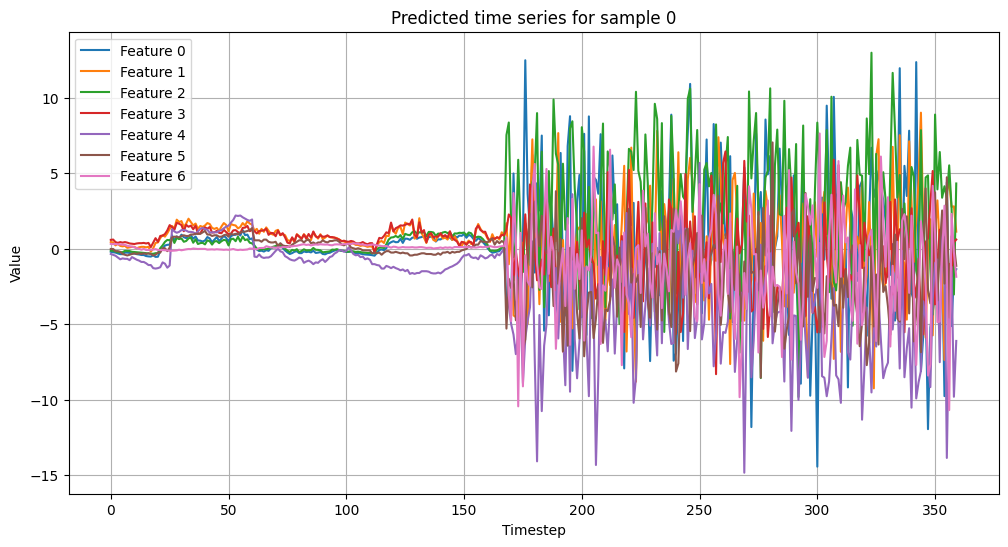

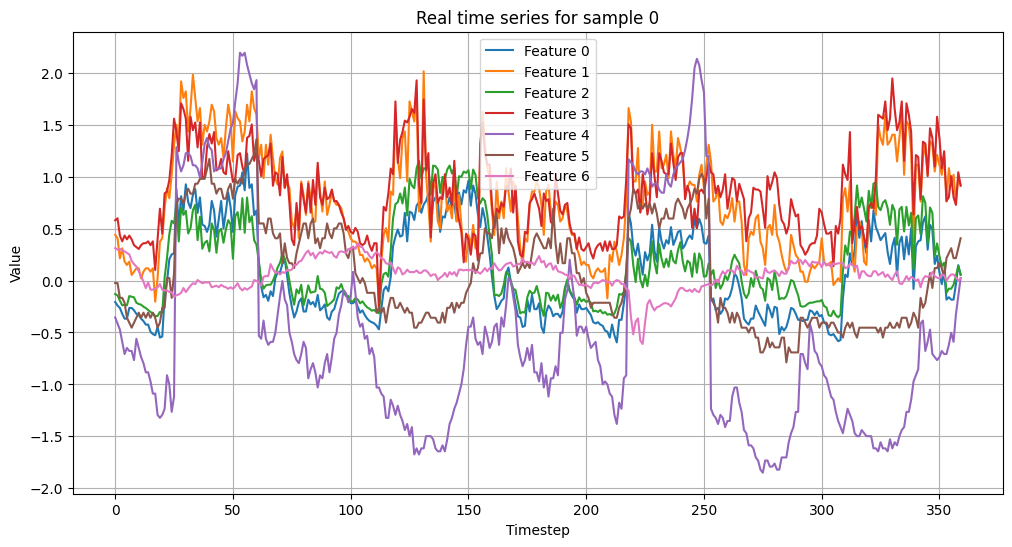

In [72]:
# x: (B, T, D)
sample_idx = 0
x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()


# Training

In [73]:
# training function with early stopping

def train_ratd(
    model,
    train_loader,
    encoder=encoder_loaded,
    retrieval_db=retrieval_db,
    k=K,
    val_loader=None,
    epochs=10,
    lr=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='best_model.pt',
    patience=10,
    drop_prob = 0.5
):
    orig_len = model.original_len
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-8
    )
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    start_epoch = 1
    epochs_no_improve = 0  # contatore per early stopping

    # === Recover Checkpoint ===
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Checkpoint found. Restart from epoch {start_epoch} with best_val_loss {best_val_loss:.6f}.")

    for epoch in range(start_epoch, epochs + 1):
        model.train()
        train_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
        for x, timestamps, _ in pbar:
            # retrieve the top-k similar series
            if random.random() < drop_prob:
                xr = None
                x, timestamps = x.to(device), timestamps.to(device)
            else : 
                xr = retrieve_knn(x[:, 0:orig_len, :], encoder, faiss_index, xr_target, k=k, device=device)
                x, xr, timestamps = x.to(device), xr.to(device), timestamps.to(device)

            optimizer.zero_grad()
            loss = model.calc_loss(x, timestamps, xr=xr)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}")

        # === VALIDATION ===
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, timestamps, _ in val_loader:
                    if random.random() < drop_prob:
                        xr = None
                        x, timestamps = x.to(device), timestamps.to(device)
                    else : 
                        xr = retrieve_knn(x[:, 0:orig_len, :], encoder, faiss_index, xr_target, k=k, device=device)
                        x, xr, timestamps = x.to(device), xr.to(device), timestamps.to(device)
                    pred = model(x, timestamps, xr=xr)
                    loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch}: Val MSE = {avg_val_loss:.6f}")

            scheduler.step(avg_val_loss)

            # === Check improvement for early stopping ===
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_val_loss': best_val_loss
                }, save_path)
                print(f"Saved best model at {save_path}")
            else:
                epochs_no_improve += 1

            # === Early Stopping ===
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch} epochs. Best Val Loss = {best_val_loss:.6f}")
                break

# Training without reference

We trained the model without using the reference for the generation process, to see how this affect on the quality of the predictions made by the model.

In [74]:
!rm /kaggle/working/models/ratd_best_without_reference.pt

In [75]:
B, orig_len, D = 32, 168, 7
K = 3
C = 4
side_dim = 48
emb_dim = 16
T = 192

alt_model = NsRATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=1,
    # freeze_estimators = False
).to(device)

print(f"RATD parameters: {count_parameters(alt_model):,}")

RATD parameters: 247,535


In [76]:
train_ratd(
    model=alt_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    lr=1e-3,
    save_path="models/ratd_best_without_reference.pt",
    drop_prob = 1.0
)

Epoch 1 [Train]: 100%|██████████| 1084/1084 [01:47<00:00, 10.08it/s, loss=1.47]


Epoch 1: Train Loss = 1.546493
Epoch 1: Val MSE = 1.337700
Saved best model at models/ratd_best_without_reference.pt


Epoch 2 [Train]: 100%|██████████| 1084/1084 [01:47<00:00, 10.11it/s, loss=1.35]


Epoch 2: Train Loss = 1.327313
Epoch 2: Val MSE = 1.339293


Epoch 3 [Train]: 100%|██████████| 1084/1084 [01:48<00:00,  9.98it/s, loss=1.28]


Epoch 3: Train Loss = 1.306222
Epoch 3: Val MSE = 1.329204
Saved best model at models/ratd_best_without_reference.pt


Epoch 4 [Train]: 100%|██████████| 1084/1084 [01:46<00:00, 10.22it/s, loss=1.28]


Epoch 4: Train Loss = 1.295345
Epoch 4: Val MSE = 1.317399
Saved best model at models/ratd_best_without_reference.pt


Epoch 5 [Train]: 100%|██████████| 1084/1084 [01:46<00:00, 10.20it/s, loss=1.31]


Epoch 5: Train Loss = 1.281128
Epoch 5: Val MSE = 1.306883
Saved best model at models/ratd_best_without_reference.pt


Epoch 6 [Train]: 100%|██████████| 1084/1084 [01:46<00:00, 10.19it/s, loss=1.41]


Epoch 6: Train Loss = 1.275001
Epoch 6: Val MSE = 1.286326
Saved best model at models/ratd_best_without_reference.pt


Epoch 7 [Train]: 100%|██████████| 1084/1084 [01:46<00:00, 10.18it/s, loss=1.34]


Epoch 7: Train Loss = 1.268688
Epoch 7: Val MSE = 1.249190
Saved best model at models/ratd_best_without_reference.pt


Epoch 8 [Train]: 100%|██████████| 1084/1084 [01:46<00:00, 10.15it/s, loss=1.3] 


Epoch 8: Train Loss = 1.262299
Epoch 8: Val MSE = 1.169490
Saved best model at models/ratd_best_without_reference.pt


Epoch 9 [Train]: 100%|██████████| 1084/1084 [01:47<00:00, 10.05it/s, loss=1.26]


Epoch 9: Train Loss = 1.262045
Epoch 9: Val MSE = 1.116424
Saved best model at models/ratd_best_without_reference.pt


Epoch 10 [Train]: 100%|██████████| 1084/1084 [01:48<00:00, 10.02it/s, loss=1.36]


Epoch 10: Train Loss = 1.256140
Epoch 10: Val MSE = 1.089944
Saved best model at models/ratd_best_without_reference.pt


Epoch 11 [Train]: 100%|██████████| 1084/1084 [01:46<00:00, 10.21it/s, loss=1.38]


Epoch 11: Train Loss = 1.250801
Epoch 11: Val MSE = 1.066738
Saved best model at models/ratd_best_without_reference.pt


Epoch 12 [Train]: 100%|██████████| 1084/1084 [01:45<00:00, 10.26it/s, loss=1.23]


Epoch 12: Train Loss = 1.250319
Epoch 12: Val MSE = 1.055134
Saved best model at models/ratd_best_without_reference.pt


Epoch 13 [Train]: 100%|██████████| 1084/1084 [01:45<00:00, 10.26it/s, loss=1.26]


Epoch 13: Train Loss = 1.246312
Epoch 13: Val MSE = 1.049092
Saved best model at models/ratd_best_without_reference.pt


Epoch 14 [Train]: 100%|██████████| 1084/1084 [01:45<00:00, 10.23it/s, loss=1.21]


Epoch 14: Train Loss = 1.243811
Epoch 14: Val MSE = 1.039711
Saved best model at models/ratd_best_without_reference.pt


Epoch 15 [Train]: 100%|██████████| 1084/1084 [01:45<00:00, 10.28it/s, loss=1.26]


Epoch 15: Train Loss = 1.243633
Epoch 15: Val MSE = 1.041885


Epoch 16 [Train]: 100%|██████████| 1084/1084 [01:45<00:00, 10.27it/s, loss=1.19]


Epoch 16: Train Loss = 1.239015
Epoch 16: Val MSE = 1.027635
Saved best model at models/ratd_best_without_reference.pt


Epoch 17 [Train]: 100%|██████████| 1084/1084 [01:46<00:00, 10.22it/s, loss=1.2] 


Epoch 17: Train Loss = 1.235553
Epoch 17: Val MSE = 1.034560


Epoch 18 [Train]: 100%|██████████| 1084/1084 [01:47<00:00, 10.09it/s, loss=1.22]


Epoch 18: Train Loss = 1.233727
Epoch 18: Val MSE = 1.027204
Saved best model at models/ratd_best_without_reference.pt


Epoch 19 [Train]: 100%|██████████| 1084/1084 [01:46<00:00, 10.17it/s, loss=1.21]


Epoch 19: Train Loss = 1.231376
Epoch 19: Val MSE = 1.017917
Saved best model at models/ratd_best_without_reference.pt


Epoch 20 [Train]: 100%|██████████| 1084/1084 [01:46<00:00, 10.15it/s, loss=1.24]


Epoch 20: Train Loss = 1.228565
Epoch 20: Val MSE = 1.016313
Saved best model at models/ratd_best_without_reference.pt


In [ ]:
train_ratd(
    model=alt_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=1e-3,
    save_path="models/ratd_best_without_reference.pt",
    drop_prob = 1.0
)

# Training with reference

In [77]:
!rm /kaggle/working/models/ratd_best.pt

In [78]:
B, orig_len, D = 32, 168, 7
K = 3
C = 4
side_dim = 48
emb_dim = 16
T = 192

model = NsRATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=1,
    # freeze_estimators = False
).to(device)

print(f"RATD parameters: {count_parameters(model):,}")

RATD parameters: 247,535


In [79]:
train_ratd(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    lr=1e-3,
    save_path="models/ratd_best.pt",
    drop_prob = 0.0
)

Epoch 1 [Train]: 100%|██████████| 1084/1084 [01:55<00:00,  9.39it/s, loss=1.31]


Epoch 1: Train Loss = 1.561815
Epoch 1: Val MSE = 1.332785
Saved best model at models/ratd_best.pt


Epoch 2 [Train]: 100%|██████████| 1084/1084 [01:54<00:00,  9.48it/s, loss=1.27]


Epoch 2: Train Loss = 1.325642
Epoch 2: Val MSE = 1.326549
Saved best model at models/ratd_best.pt


Epoch 3 [Train]: 100%|██████████| 1084/1084 [01:52<00:00,  9.61it/s, loss=1.42]


Epoch 3: Train Loss = 1.309468
Epoch 3: Val MSE = 1.346060


Epoch 4 [Train]: 100%|██████████| 1084/1084 [01:53<00:00,  9.59it/s, loss=1.29]


Epoch 4: Train Loss = 1.296420
Epoch 4: Val MSE = 1.323685
Saved best model at models/ratd_best.pt


Epoch 5 [Train]: 100%|██████████| 1084/1084 [01:52<00:00,  9.59it/s, loss=1.28]


Epoch 5: Train Loss = 1.286330
Epoch 5: Val MSE = 1.316731
Saved best model at models/ratd_best.pt


Epoch 6 [Train]: 100%|██████████| 1084/1084 [01:52<00:00,  9.59it/s, loss=1.32]


Epoch 6: Train Loss = 1.277192
Epoch 6: Val MSE = 1.251988
Saved best model at models/ratd_best.pt


Epoch 7 [Train]: 100%|██████████| 1084/1084 [01:54<00:00,  9.48it/s, loss=1.29]


Epoch 7: Train Loss = 1.268690
Epoch 7: Val MSE = 1.183306
Saved best model at models/ratd_best.pt


Epoch 8 [Train]: 100%|██████████| 1084/1084 [01:52<00:00,  9.60it/s, loss=1.33]


Epoch 8: Train Loss = 1.262890
Epoch 8: Val MSE = 1.171309
Saved best model at models/ratd_best.pt


Epoch 9 [Train]: 100%|██████████| 1084/1084 [01:52<00:00,  9.63it/s, loss=1.24]


Epoch 9: Train Loss = 1.258013
Epoch 9: Val MSE = 1.156600
Saved best model at models/ratd_best.pt


Epoch 10 [Train]: 100%|██████████| 1084/1084 [01:52<00:00,  9.60it/s, loss=1.21]


Epoch 10: Train Loss = 1.255710
Epoch 10: Val MSE = 1.146500
Saved best model at models/ratd_best.pt


Epoch 11 [Train]: 100%|██████████| 1084/1084 [01:56<00:00,  9.32it/s, loss=1.31]


Epoch 11: Train Loss = 1.250951
Epoch 11: Val MSE = 1.144824
Saved best model at models/ratd_best.pt


Epoch 12 [Train]: 100%|██████████| 1084/1084 [01:56<00:00,  9.34it/s, loss=1.21]


Epoch 12: Train Loss = 1.250787
Epoch 12: Val MSE = 1.132327
Saved best model at models/ratd_best.pt


Epoch 13 [Train]: 100%|██████████| 1084/1084 [01:56<00:00,  9.29it/s, loss=1.25]


Epoch 13: Train Loss = 1.246521
Epoch 13: Val MSE = 1.128629
Saved best model at models/ratd_best.pt


Epoch 14 [Train]: 100%|██████████| 1084/1084 [01:56<00:00,  9.29it/s, loss=1.29]


Epoch 14: Train Loss = 1.243584
Epoch 14: Val MSE = 1.097154
Saved best model at models/ratd_best.pt


Epoch 15 [Train]: 100%|██████████| 1084/1084 [01:56<00:00,  9.29it/s, loss=1.23]


Epoch 15: Train Loss = 1.239395
Epoch 15: Val MSE = 1.037085
Saved best model at models/ratd_best.pt


Epoch 16 [Train]: 100%|██████████| 1084/1084 [01:56<00:00,  9.33it/s, loss=1.15]


Epoch 16: Train Loss = 1.238260
Epoch 16: Val MSE = 0.995524
Saved best model at models/ratd_best.pt


Epoch 17 [Train]: 100%|██████████| 1084/1084 [01:55<00:00,  9.39it/s, loss=1.19]


Epoch 17: Train Loss = 1.234909
Epoch 17: Val MSE = 0.987840
Saved best model at models/ratd_best.pt


Epoch 18 [Train]: 100%|██████████| 1084/1084 [01:55<00:00,  9.37it/s, loss=1.24]


Epoch 18: Train Loss = 1.231037
Epoch 18: Val MSE = 0.979494
Saved best model at models/ratd_best.pt


Epoch 19 [Train]: 100%|██████████| 1084/1084 [01:54<00:00,  9.43it/s, loss=1.2] 


Epoch 19: Train Loss = 1.230064
Epoch 19: Val MSE = 0.982052


Epoch 20 [Train]: 100%|██████████| 1084/1084 [01:55<00:00,  9.42it/s, loss=1.2] 


Epoch 20: Train Loss = 1.225847
Epoch 20: Val MSE = 0.979498


# Results

In [82]:
B, orig_len, D = 32, 168, 7
K = 3
C = 4
side_dim = 48
emb_dim = 16
T = 192

model = NsRATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=1
).to(device)

alt_model = NsRATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=1
).to(device)

In [83]:
checkpoint = torch.load("models/ratd_best.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

checkpoint = torch.load("models/ratd_best_without_reference.pt", map_location=device)
# print(checkpoint['model_state_dict'])
alt_model.load_state_dict(checkpoint['model_state_dict'])
alt_model.eval()

NsRATD(
  (ldte): LearnableDiffusionTimestepEmbedding(
    (embedding): Embedding(20, 16)
  )
  (side_module): SideInformation()
  (layers): ModuleList(
    (0): DenoisingLayer(
      (rma): MultiHeadRMA(
        (q_proj): Linear(in_features=7, out_features=128, bias=True)
        (k_proj): Linear(in_features=14, out_features=128, bias=True)
        (v_proj): Linear(in_features=21, out_features=128, bias=True)
        (alt_k_proj): Linear(in_features=7, out_features=128, bias=True)
        (alt_v_proj): Linear(in_features=14, out_features=128, bias=True)
        (out): Linear(in_features=128, out_features=7, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (time_feature_conv): CausalConv2d(
        (conv): Conv2d(48, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (diff_timestep_emb_conv): Conv1d(16, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (ln1): LayerNorm((192, 7), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm(

In [84]:
for xb, timestamps, _ in test_loader:
    
    xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
    xb, xr, timestamps= xb.to(device), xr.to(device), timestamps.to(device)
    output = model(xb, timestamps, xr, n_samples = 100)
    alt_output = alt_model(xb, timestamps, n_samples = 100)
    print(nn.MSELoss()(output[:, 168:, :], xb[:, 168:, :]))
    print(nn.MSELoss()(alt_output[:, 168:, :], xb[:, 168:, :]))
    break

tensor(0.3102, device='cuda:0')
tensor(0.3062, device='cuda:0')


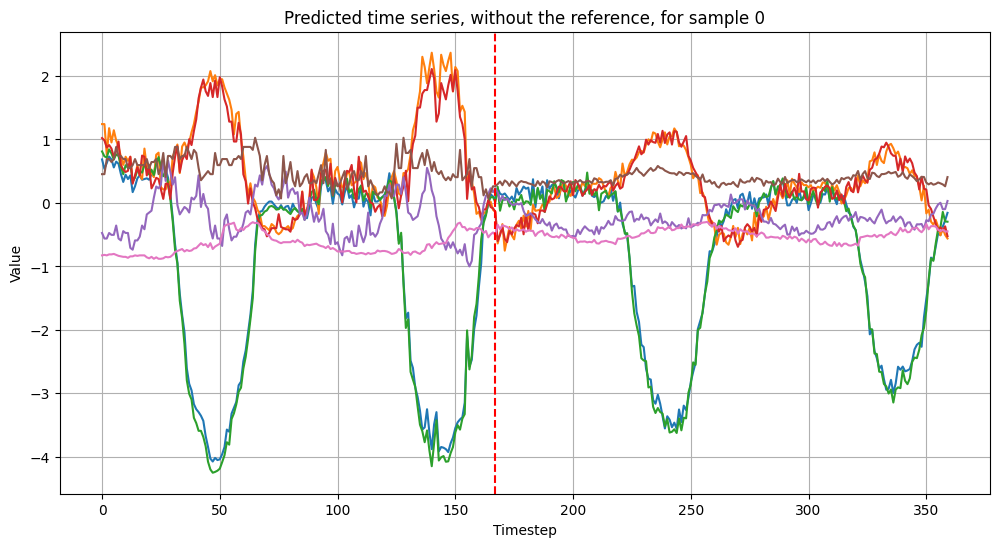

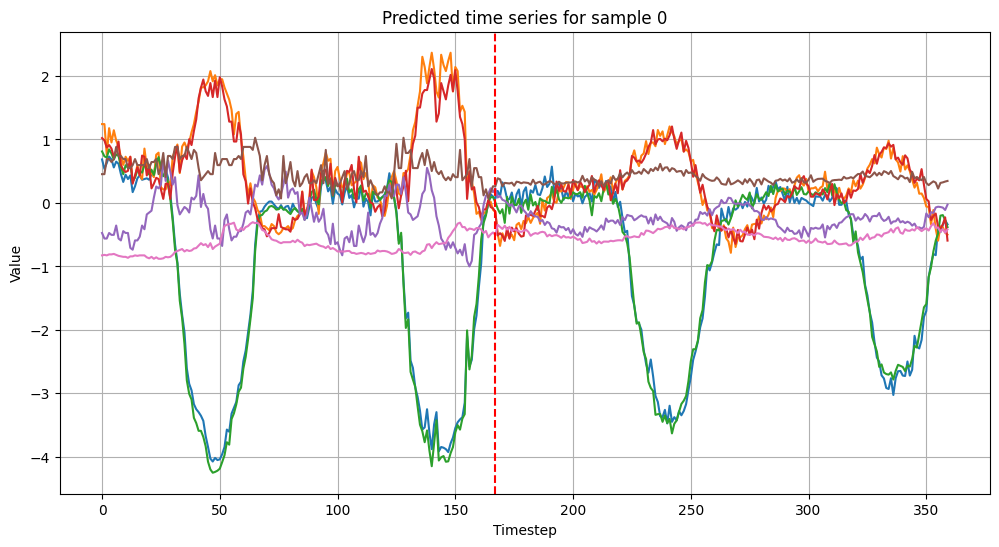

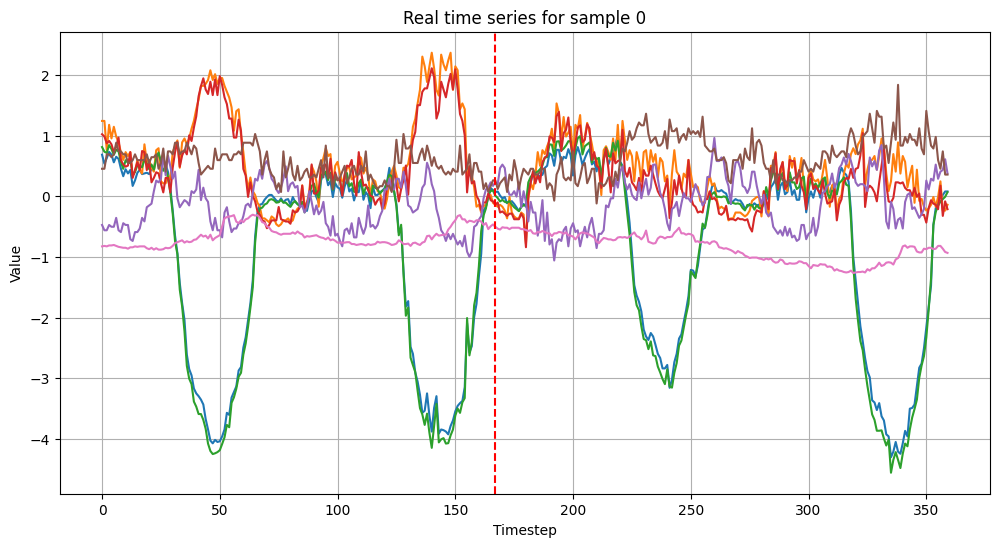

In [85]:
# x: (B, T, D)
#for sample_idx in range(B):
sample_idx = 0    
x_sample = alt_output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series, without the reference, for sample {sample_idx}")
plt.axvline(x=orig_len - 1, color='red', linestyle='--')
plt.grid(True)
plt.show()

x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.axvline(x=orig_len - 1, color='red', linestyle='--')
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.axvline(x=orig_len - 1, color='red', linestyle='--')
plt.grid(True)
plt.show()

The visual and statistical (0.084 vs 0.143 of MSE) results acknowledge the improvement brought by the guidance of a reference during the generation process.

In [86]:
mse_fn = nn.MSELoss()
mae_fn = nn.L1Loss()
test_mse = 0
test_mae = 0

with torch.no_grad():
    for xb, timestamps, _ in test_loader:
        xb, timestamps = xb.to(device), timestamps.to(device)
        output = alt_model(xb, timestamps, n_samples = 100)

        mse_loss = mse_fn(output[:, orig_len:, :], xb[:, orig_len:, :])
        mae_loss = mae_fn(output[:, orig_len:, :], xb[:, orig_len:, :])
        
        test_mse += mse_loss
        test_mae += mae_loss

avg_test_mse = test_mse / len(test_loader)
avg_test_mae = test_mae / len(test_loader)

In [87]:
print(f"Test MSE = {avg_test_mse:.6f}")
print(f"Test MAE = {avg_test_mae:.6f}")

Test MSE = 0.486513
Test MAE = 0.446003


In [88]:
mse_fn = nn.MSELoss()
mae_fn = nn.L1Loss()
test_mse = 0
test_mae = 0

with torch.no_grad():
    for xb, timestamps, _ in test_loader:
        xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
        xb, xr, timestamps= xb.to(device), xr.to(device), timestamps.to(device)
        output = model(xb, timestamps, xr, n_samples = 100)

        mse_loss = mse_fn(output[:, orig_len:, :], xb[:, orig_len:, :])
        mae_loss = mae_fn(output[:, orig_len:, :], xb[:, orig_len:, :])
        
        test_mse += mse_loss
        test_mae += mae_loss

avg_test_mse = test_mse / len(test_loader)
avg_test_mae = test_mae / len(test_loader)

In [89]:
print(f"Test MSE = {avg_test_mse:.6f}")
print(f"Test MAE = {avg_test_mae:.6f}")

Test MSE = 0.483177
Test MAE = 0.447725


In [79]:
def plot_model_parameters(model):
    """
    Mostra istogrammi dei pesi learnable di un modello PyTorch.
    max_params: massimo numero di layer da visualizzare.
    """
    params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
    
    for i, (name, p) in enumerate(params):
        
        data = p.data.cpu().numpy().flatten()
        plt.figure(figsize=(6,3))
        plt.hist(data, bins=50, alpha=0.7)
        plt.title(f"{name} (shape {tuple(p.shape)})")
        plt.xlabel("Weight value")
        plt.ylabel("Frequency")
        plt.show()

In [ ]:
plot_model_parameters(alt_model)

The performance was measured using the Mean Squared Error (MSE) metric. On the validation set, the model achieved a MSE of 0.084, while on the test set it achieved a slightly lower MSE of 0.082, indicating good generalization capabilities. A more detailed analysis revealed that, among all features, only one, the median_list_price, exhibited a significantly higher error, with a MSE of approximately 0.86 on the test set. Notably, this particular feature also had a standard deviation more than ten times larger than its onw mean, there were some outliers that made difficult to generalize on this feature, while other features presented a standard deviation close to or lower than the mean.
Overall, the results indicate robust performance across most features, with the exception of the outlier feature influenced by its inherent statistical characteristics.

# Final Considerations

The results obtained in our experiments are promising and show comparable performance to those reported in the reference paper. Specifically, despite working with a similar number of features, our model achieved prediction errors in a similar range, indicating that our architecture and preprocessing pipeline were effective. While we attempted to replicate the experimental conditions as closely as possible, including the use of publicly available platforms such as Kaggle for training, it is important to note that we did not have access to the same computational resources as the original study. This limitation may have affected training duration, batch size, and model complexity. Nevertheless, the similarity in the results suggests that our implementation closely resembles the original approach, both in design and in effectiveness, reinforcing the validity of our experimental setup.